In [3]:
import os
import time
import io
import base64

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    fbeta_score
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
df = pd.read_pickle("/kaggle/input/final-preds/all_preds.pkl")

In [5]:
df.head()

,id,lgbm_42,lgbm_52,lgbm_62,lgbm_72,lgbm_82,ensemble,eva_1,edgenext,labels
0,ISIC_0015670,0.015197,0.012859,0.018430,0.014540,0.013881,0.014981,0.039354,0.005510,0
1,ISIC_0015845,0.994896,0.994877,0.994858,0.994904,0.994728,0.994852,0.235056,0.213351,0
2,ISIC_0015864,0.009457,0.008784,0.008883,0.007815,0.008454,0.008679,0.013793,0.003092,0
3,ISIC_0015902,0.017314,0.013926,0.014249,0.014940,0.013991,0.014884,0.028597,0.034764,0
4,ISIC_0024200,0.203507,0.222469,0.274706,0.196490,0.217909,0.223016,0.067254,0.009865,0


In [8]:
df_temp = pd.read_pickle("/kaggle/input/final-preds/eva02_02_preds.pkl")
df_temp.head()

,id,prediction
0,ISIC_0015670,0.011655
1,ISIC_0015845,0.506825
2,ISIC_0015864,0.000985
3,ISIC_0015902,0.026712
4,ISIC_0024200,0.022127


In [9]:
df["id"].equals(df_temp["id"])

True

In [11]:
df["eva_2"] = df_temp["prediction"]
df.head()

,id,lgbm_42,lgbm_52,lgbm_62,lgbm_72,lgbm_82,ensemble,eva_1,edgenext,labels,eva_2
0,ISIC_0015670,0.015197,0.012859,0.018430,0.014540,0.013881,0.014981,0.039354,0.005510,0,0.011655
1,ISIC_0015845,0.994896,0.994877,0.994858,0.994904,0.994728,0.994852,0.235056,0.213351,0,0.506825
2,ISIC_0015864,0.009457,0.008784,0.008883,0.007815,0.008454,0.008679,0.013793,0.003092,0,0.000985
3,ISIC_0015902,0.017314,0.013926,0.014249,0.014940,0.013991,0.014884,0.028597,0.034764,0,0.026712
4,ISIC_0024200,0.203507,0.222469,0.274706,0.196490,0.217909,0.223016,0.067254,0.009865,0,0.022127


In [14]:
class_1_df = df[df['labels'] == 1]
class_0_df = df[df['labels'] == 0]
len(class_1_df)

393

In [19]:
class_1_df_train, class_1_df_val = train_test_split(class_1_df, test_size=0.2, random_state=42)
class_0_df_train, class_0_df_val = train_test_split(class_0_df, test_size=0.2, random_state=42)

import pandas as pd


class_0_df_train_sam = class_0_df_train.sample(n=3000)  # random_state for reproducibility
class_0_df_val_sam = class_0_df_val.sample(n=1000)


In [20]:
df_train = pd.concat([class_1_df_train, class_0_df_train_sam])
df_val = pd.concat([class_1_df_val, class_0_df_val_sam])


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix

# ==== 1. Features and Labels ====
feature_cols = ['lgbm_42', 'lgbm_52', 'lgbm_62', 'lgbm_72', 'lgbm_82',
                'ensemble', 'eva_1', 'edgenext', 'eva_2']

X_train = df_train[feature_cols].values.astype(np.float32)
y_train = df_train['labels'].values.astype(np.float32)

X_val = df_val[feature_cols].values.astype(np.float32)
y_val = df_val['labels'].values.astype(np.float32)

# ==== 2. Dataset Class ====
class MetaDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(MetaDataset(X_train, y_train), batch_size=32, shuffle=True)

# ==== 3. Device ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==== 4. Neural Net ====
class MetaNN(nn.Module):
    def __init__(self, input_dim):
        super(MetaNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 1)   # logits only
        )
    def forward(self, x):
        return self.net(x)

model = MetaNN(input_dim=len(feature_cols)).to(device)

# ==== 5. Compute pos_weight ====
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

# ==== 6. Loss + Optimizer ====
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==== 7. Training with validation confusion matrix ====
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch).squeeze()
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
        model.eval()
        with torch.no_grad():
            val_logits = model(torch.tensor(X_val).to(device)).squeeze()
            val_preds = torch.sigmoid(val_logits).cpu().numpy()
        
        val_labels_pred = (val_preds > 0.5).astype(int)
        
        cm = confusion_matrix(y_val, val_labels_pred)
        val_accuracy = (val_labels_pred == y_val).mean()
        val_error = 1 - val_accuracy
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
        print("Validation Confusion Matrix:\n", cm)
        print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Error: {val_error:.4f}")

Using device: cuda
Epoch 1/20, Loss: 1.1058
Validation Confusion Matrix:
 [[863 137]
 [  0  79]]
Epoch 2/20, Loss: 0.5169
Validation Confusion Matrix:
 [[917  83]
 [  2  77]]
Epoch 3/20, Loss: 0.3393
Validation Confusion Matrix:
 [[922  78]
 [  2  77]]
Epoch 4/20, Loss: 0.3394
Validation Confusion Matrix:
 [[917  83]
 [  2  77]]
Epoch 5/20, Loss: 0.3237
Validation Confusion Matrix:
 [[923  77]
 [  4  75]]
Epoch 6/20, Loss: 0.3319
Validation Confusion Matrix:
 [[913  87]
 [  2  77]]
Epoch 7/20, Loss: 0.3060
Validation Confusion Matrix:
 [[930  70]
 [  5  74]]
Epoch 8/20, Loss: 0.2977
Validation Confusion Matrix:
 [[926  74]
 [  4  75]]
Epoch 9/20, Loss: 0.3018
Validation Confusion Matrix:
 [[945  55]
 [  5  74]]
Epoch 10/20, Loss: 0.3014
Validation Confusion Matrix:
 [[913  87]
 [  2  77]]
Epoch 11/20, Loss: 0.3103
Validation Confusion Matrix:
 [[923  77]
 [  3  76]]
Epoch 12/20, Loss: 0.3163
Validation Confusion Matrix:
 [[922  78]
 [  3  76]]
Epoch 13/20, Loss: 0.2947
Validation Confu

In [24]:
import torch
import numpy as np

def evaluate_and_append(df, model, feature_cols, device, threshold=0.5):
    """
    Evaluates a trained meta-model on a DataFrame and appends predictions.
    
    Args:
        df (pd.DataFrame): Input DataFrame with model predictions as features
        model (torch.nn.Module): Trained PyTorch model
        feature_cols (list): Columns used as input features
        device (torch.device): 'cuda' or 'cpu'
        threshold (float): Classification threshold for binary labels
    
    Returns:
        pd.DataFrame with appended prediction columns
    """
    # Prepare data
    X = df[feature_cols].values.astype(np.float32)
    X_tensor = torch.tensor(X).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
    
    # Binary predictions
    preds = (probs > threshold).astype(int)
    
    # Append to DataFrame
    df = df.copy()
    df["meta_prob"] = probs   # probability
    df["meta_pred"] = preds   # final prediction
    
    return df


# ==== Example Usage ====
# Suppose you have a new dataset df_test with the same feature columns
df_test_with_preds = evaluate_and_append(df, model, feature_cols, device)

df_test_with_preds.head()


,id,lgbm_42,lgbm_52,lgbm_62,lgbm_72,lgbm_82,ensemble,eva_1,edgenext,labels,eva_2,meta_prob,meta_pred
0,ISIC_0015670,0.015197,0.012859,0.018430,0.014540,0.013881,0.014981,0.039354,0.005510,0,0.011655,0.008737,0
1,ISIC_0015845,0.994896,0.994877,0.994858,0.994904,0.994728,0.994852,0.235056,0.213351,0,0.506825,0.898572,1
2,ISIC_0015864,0.009457,0.008784,0.008883,0.007815,0.008454,0.008679,0.013793,0.003092,0,0.000985,0.007719,0
3,ISIC_0015902,0.017314,0.013926,0.014249,0.014940,0.013991,0.014884,0.028597,0.034764,0,0.026712,0.008730,0
4,ISIC_0024200,0.203507,0.222469,0.274706,0.196490,0.217909,0.223016,0.067254,0.009865,0,0.022127,0.020064,0


In [ ]:
cm = confusion_matrix(all_targets, pred_labels, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print(
    f"Precision: {precision:.4f} | Recall: {recall:.4f} | "
    f"F1: {f1:.4f} | F2: {f2:.4f} | Specificity: {specificity:.4f} | "
    f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}"
)

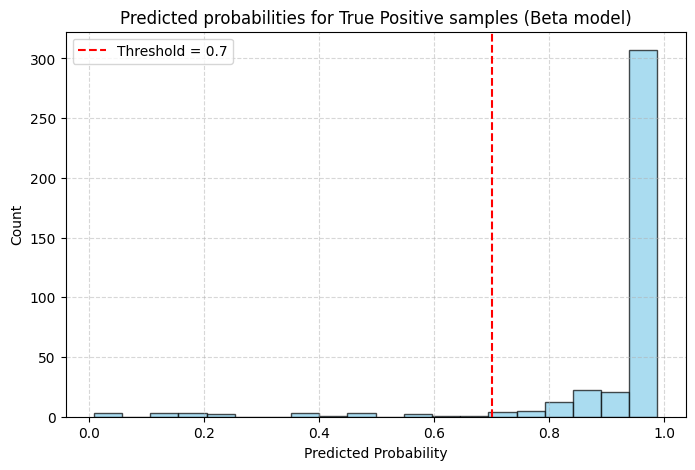

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy arrays if they aren't already
all_targets = np.array(df_test_with_preds["labels"])
all_preds = np.array(df_test_with_preds["meta_prob"])

# Filter only true positive samples (actual label = 1)
true_positive_mask = (all_targets == 1)
true_positive_preds = all_preds[true_positive_mask]

# Plot histogram of predictions for true positives
plt.figure(figsize=(8, 5))
plt.hist(true_positive_preds, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.title("Predicted probabilities for True Positive samples (Beta model)")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

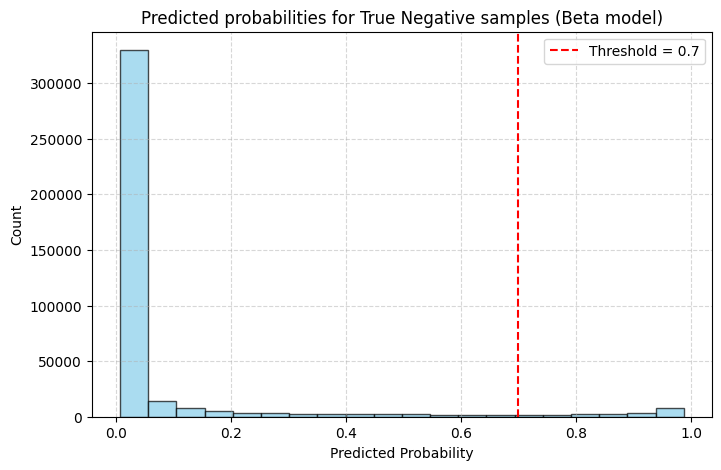

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy arrays if they aren't already
all_targets = np.array(df_test_with_preds["labels"])
all_preds = np.array(df_test_with_preds["meta_prob"])

# Filter only true positive samples (actual label = 1)
true_positive_mask = (all_targets == 0)
true_positive_preds = all_preds[true_positive_mask]

# Plot histogram of predictions for true positives
plt.figure(figsize=(8, 5))
plt.hist(true_positive_preds, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.title("Predicted probabilities for True Negative samples (Beta model)")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [32]:
threshold = 0.7
pred_labels = (all_preds >= threshold).astype(int)

acc = accuracy_score(all_targets, pred_labels)
precision = precision_score(all_targets, pred_labels, zero_division=0)
recall = recall_score(all_targets, pred_labels, zero_division=0)

pred_labels = (all_preds >= threshold).astype(int)

f1 = fbeta_score(all_targets, pred_labels, beta=1)  # regular F1
f2 = fbeta_score(all_targets, pred_labels, beta=2)  # F2 score

balanced_acc = balanced_accuracy_score(all_targets, pred_labels)

cm = confusion_matrix(all_targets, pred_labels, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print(
    f"Precision: {precision:.4f} | Recall: {recall:.4f} | "
    f"F1: {f1:.4f} | F2: {f2:.4f} | Specificity: {specificity:.4f} | "
    f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}"
)
prec, rec, thresh = precision_recall_curve(all_targets, all_preds)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)  # avoid div by zero
best_thresh = thresh[np.argmax(f1_scores)]
print(f"Best threshold for F1 this epoch: {best_thresh:.4f}")

Precision: 0.0190 | Recall: 0.9440 | F1: 0.0373 | F2: 0.0881 | Specificity: 0.9523 | TP: 371, FP: 19124, FN: 22, TN: 381542
Best threshold for F1 this epoch: 0.9832


In [36]:
import numpy as np
from sklearn.metrics import roc_auc_score

def comp_pauc(y_true, y_pred, min_tpr=0.80):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Flip so that positive = 0, because of the way v_gt is defined
    v_gt = abs(y_true - 1)
    v_pred = 1.0 - y_pred

    max_fpr = abs(1 - min_tpr)
    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)

    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / 0.5 * (pauc_scaled - 0.5)
    return pauc

# Example usage:
# Suppose you already have lists
y_true_list = [0, 1, 0, 1, 1]
y_pred_list = [0.1, 0.8, 0.4, 0.9, 0.7]

print("pAUC:", comp_pauc(all_targets, all_preds))

pAUC: 0.1883331003243467


In [37]:
df_test_with_preds.to_pickle("df_with_beta_final_result.pkl")

In [38]:
torch.save(model, "meta_nn_full.pth")